In [1]:
%pip install matplotlib transformers datasets emojis

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd
import sklearn.metrics
import emojis
import torch
import datasets
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, pipeline

# DEVICE
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
# PARAMETERS
dataset_name = 'tamilmixsentiment'

# batch_size, language_model_name = 64, 'distilbert-base-uncased'
# batch_size, language_model_name = 8, 'distilbert-base-uncased'  # sagemaker studio lab
# batch_size, language_model_name = 32, 'bert-base-multilingual-cased'
# batch_size, language_model_name = 16, 'bert-base-multilingual-cased'
# batch_size, language_model_name = 32, 'xlm-roberta-large'


# DATA
# dataset = datasets.load_dataset('emotion')
dataset = datasets.load_dataset(dataset_name)

dataset = datasets.DatasetDict(
    {k: v.shuffle(2023).select(range(int(v.num_rows * 0.2))) for k, v in dataset.items()}
)

print(dataset)
dataset['train'].to_pandas()

Found cached dataset tamilmixsentiment (/home/studio-lab-user/.cache/huggingface/datasets/tamilmixsentiment/default/0.0.0/887420eecaf868ac6c10990649e49d10467e4cd4dffb98a6f20e4fe7c58df390)


  0%|          | 0/3 [00:00<?, ?it/s]

Loading cached shuffled indices for dataset at /home/studio-lab-user/.cache/huggingface/datasets/tamilmixsentiment/default/0.0.0/887420eecaf868ac6c10990649e49d10467e4cd4dffb98a6f20e4fe7c58df390/cache-e0dc15cb3461e70b.arrow
Loading cached shuffled indices for dataset at /home/studio-lab-user/.cache/huggingface/datasets/tamilmixsentiment/default/0.0.0/887420eecaf868ac6c10990649e49d10467e4cd4dffb98a6f20e4fe7c58df390/cache-ef0be8f2bf001be5.arrow
Loading cached shuffled indices for dataset at /home/studio-lab-user/.cache/huggingface/datasets/tamilmixsentiment/default/0.0.0/887420eecaf868ac6c10990649e49d10467e4cd4dffb98a6f20e4fe7c58df390/cache-69d2a8d0c35d823e.arrow


DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 2267
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 252
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 629
    })
})


,text,label
0,Bgm Vera level.. Yuvan rocks,0
1,Chiyaan Anna vera level,0
2,Semma fulla Rajinism than ..... Semma super,0
3,Oruthar mela nenga visawasam katrarukaha innor...,0
4,petta parak... Kola Kandula iruken. Thalaiva r...,0
...,...,...
2262,Super I m waiting kannada trailer .....,1
2263,1st tym ungaal ipdi pakro Thala 🤘🤘,0
2264,Mass la pakka mass thalaivar athiradi,0
2265,Bigil movie trailerku 240k dislike podanum unm...,0


In [4]:
# TOKENS
tokenizer = AutoTokenizer.from_pretrained(language_model_name)

# the tokenizer is not prepared for emojis
print(tokenizer.tokenize('🤘'))

# here I add emojis as new tokens
my_emojis = [list(emojis.get(x)) for x in dataset['train']['text']]
my_emojis = [y for x in my_emojis for y in x]
print(pd.Series(my_emojis).value_counts())

tokenizer.add_tokens(list(set(my_emojis)))

print(tokenizer.tokenize('🤘'))

# now we can generate embeddings for our text
def tokenize(batch):
    return tokenizer(batch['text'], padding=True, truncation=True)


dataset_encoded = dataset.map(tokenize, batched=True, batch_size=None)
dataset_encoded.set_format('torch')
dataset_encoded

['[UNK]']
🤩    23
🤣    23
🤔    20
🤘    16
🤗     7
🥰     4
🤟     2
🧡     2
🤢     2
🦁     2
🤦     2
🤑     1
🤫     1
🥳     1
🤒     1
🦂     1
🤭     1
🤮     1
🤜     1
🤧     1
🤞     1
🤓     1
🤖     1
🥁     1
🤙     1
🤪     1
🤷     1
dtype: int64
['🤘']


  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 2267
    })
    validation: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 252
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 629
    })
})

In [5]:
# MODEL
num_labels = len(set(dataset['train']['label']))
print('num_labels:', num_labels)

model = AutoModelForSequenceClassification.from_pretrained(
    language_model_name, num_labels=num_labels
).to(device)
model.resize_token_embeddings(len(tokenizer))

print('model.device', model.device)


# METRICS
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = sklearn.metrics.precision_recall_fscore_support(labels, preds, average='weighted')
    acc = sklearn.metrics.accuracy_score(labels, preds)
    bal = sklearn.metrics.balanced_accuracy_score(labels, preds)
    res = {
        'accuracy': acc,
        'balanced': bal,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }
    return res


# TRAINER
training_args = TrainingArguments(
    output_dir='resultados',
    num_train_epochs=3,
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    disable_tqdm=False,
    evaluation_strategy='steps',
    # logging_steps=batch_size,
    logging_steps=100,
    report_to='none',
)


my_weights = 1 / dataset['train'].to_pandas()['label'].value_counts(normalize=True).sort_index()
my_weights = np.log(my_weights)
my_weights = my_weights.tolist()
print(my_weights)


class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get('labels')
        # forward pass
        outputs = model(**inputs)
        logits = outputs.get('logits')
        # compute custom loss (suppose one has 3 labels with different weights)
        # loss_fct = nn.CrossEntropyLoss(weight=torch.tensor([1.0, 2.0, 3.0]))
        loss_fct = torch.nn.CrossEntropyLoss(weight=torch.tensor(my_weights).to(device))
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss


trainer = WeightedTrainer(
    model=model,
    tokenizer=tokenizer,
    args=training_args,
    train_dataset=dataset_encoded['train'],
    eval_dataset=dataset_encoded['validation'],
    # data_collator=data_collator,
    compute_metrics=compute_metrics,
)

# trainer = Trainer(
#     model=model,
#     tokenizer=tokenizer,
#     args=training_args,
#     train_dataset=dataset_encoded['train'],
#     eval_dataset=dataset_encoded['validation'],
#     compute_metrics=compute_metrics,
# )

print('trainer.args.device:', trainer.args.device, flush=True)

num_labels: 5


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier

model.device cuda:0
[0.4004051479117562, 2.042632883168847, 2.1967835629961057, 2.8899307435560506, 3.395479310221198]
trainer.args.device: cuda:0


In [6]:
# In[13]:
trainer.train()
trainer.save_model('resultados2')

The following columns in the training set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 2267
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 852
  Number of trainable parameters = 66978053
You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `

Step,Training Loss,Validation Loss,Accuracy,Balanced,F1,Precision,Recall
8,1.636100,1.577620,0.174603,0.205223,0.102872,0.517857,0.174603
16,1.596800,1.552196,0.587302,0.207751,0.526465,0.477084,0.587302
24,1.575200,1.533736,0.662698,0.200000,0.529525,0.440919,0.662698
32,1.594500,1.516308,0.662698,0.200000,0.528261,0.439169,0.662698
40,1.564200,1.517785,0.662698,0.200000,0.528261,0.439169,0.662698
48,1.490600,1.502843,0.662698,0.200000,0.528261,0.439169,0.662698
56,1.450200,1.485982,0.662698,0.200000,0.528261,0.439169,0.662698
64,1.457300,1.498564,0.662698,0.200000,0.528261,0.439169,0.662698
72,1.442300,1.509822,0.662698,0.200000,0.528261,0.439169,0.662698
80,1.473500,1.517807,0.662698,0.200000,0.528261,0.439169,0.662698


The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 252
  Batch size = 8
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 2

In [7]:
# EVALUATION
df = dataset['test'].to_pandas()

pipe = pipeline('sentiment-analysis', 'resultados2')
predictions = pipe(dataset['test']['text'])

df[['pred', 'prob']] = pd.DataFrame(predictions).values
df['pred'] = df['pred'].str.replace('LABEL_', '').astype(int)

df

loading configuration file resultados2/config.json
Model config DistilBertConfig {
  "_name_or_path": "resultados2",
  "activation": "gelu",
  "architectures": [
    "DistilBertForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "problem_type": "single_label_classification",
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "torch_dtype": "float32",
  "transformers_version": "4.25.1",
  "vocab_size": 30549
}

loading configuration file resultados2/config.json
Model config DistilBertConfig {
  

,text,label,pred,prob
0,Ean Anna Unaku ena achi ean engala ipdi savade...,2,1,0.394225
1,If u like trailer then like,0,0,0.271019
2,Bc konsa konda ka... Kya? 'NERKONDA' ohhh beti...,3,1,0.299284
3,ena da epadi eduthu vechurikinga . vera level ...,0,2,0.351597
4,Maranam mass maranam athuku Makkal selvan ta v...,0,0,0.438958
...,...,...,...,...
624,Thala niga vera level love u,0,0,0.692919
625,Rajani sir's akshay gi fans put ur like here,0,3,0.286796
626,Neraya neraya neraya...... Thala fans hit like,0,0,0.691776
627,Thalaivar eppavum mass than.... ilana soldrava...,0,0,0.571014


In [8]:
pd.crosstab(df['label'], df['pred'])

pred,0,1,2,3,4
label,,,,,
0,262,86,60,11,5
1,34,26,22,1,2
2,35,21,12,0,2
3,18,12,8,0,1
4,0,0,0,1,10


In [9]:
cm = sklearn.metrics.confusion_matrix(df['label'], df['pred'])
cm

array([[262,  86,  60,  11,   5],
       [ 34,  26,  22,   1,   2],
       [ 35,  21,  12,   0,   2],
       [ 18,  12,   8,   0,   1],
       [  0,   0,   0,   1,  10]])

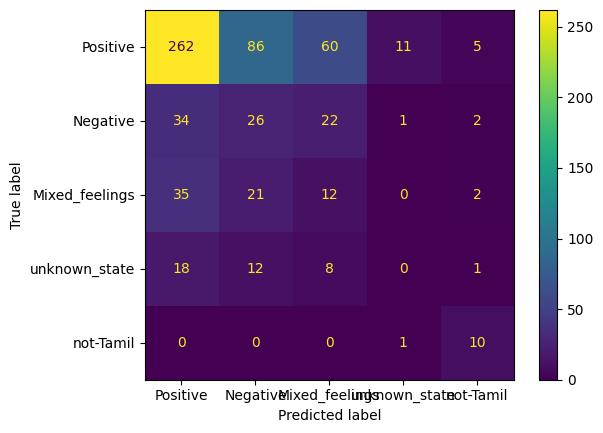

In [10]:
%matplotlib inline

disp = sklearn.metrics.ConfusionMatrixDisplay(cm, display_labels=dataset['test'].features['label'].names)
disp.plot()


In [11]:
print(sklearn.metrics.classification_report(df['label'], df['pred'], target_names=dataset['test'].features['label'].names))

                precision    recall  f1-score   support

      Positive       0.75      0.62      0.68       424
      Negative       0.18      0.31      0.23        85
Mixed_feelings       0.12      0.17      0.14        70
 unknown_state       0.00      0.00      0.00        39
     not-Tamil       0.50      0.91      0.65        11

      accuracy                           0.49       629
     macro avg       0.31      0.40      0.34       629
  weighted avg       0.55      0.49      0.51       629

